In [30]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pylab as plt
from common.layers import *
from common.gradient import numerical_gradient
from dataset.mnist import load_mnist
from collections import OrderedDict

In [ ]:
# 重みパラメータの損失関数の勾配を数値微分で調べた
# 計算に時間がかかる
# 誤差逆伝播法
# 計算グラフで理解する
# リンゴ１個１２０円で消費税１０％で２個買う
# １２０ * ２ * １.１ ＝ ２２０
# これを→に順番で計算する：順当
# 答えありきで考える：←から考える
# 連鎖律：合成関数　y = f(u),u = g(x)を微分
# y' = f'(g(x))
# y'/x' = y'/u'*u'/x':これで約分する。
# さっきのやつをむずく
# x↘　ｔ
# 　+ → * → z
# y↗　l↗
# 基本は
# ｘ　ｙ
# → F →
# 順　ｙ = F(x)
# 逆　L/y' = F'(x)/x' L:上流から来た値 or 出力値
# 乗算は入力の逆の値をかけたものが出ていく→z = t*l→ｔのルートならtで微分→z' = l
# 加算はそのまま出ていく→ x+yをxで微分 →　1

In [ ]:
# 逆伝播まとめ
# 基本は入力で出力を微分
# 加算：x+yをxで微分 →　1
# 乗算:z = t*l→ｔのルートならtで微分→z' = l

# 微分のテンプレ要確認

In [2]:
# 乗算クラス
class MulLayer:
# コンストラクタでインスタンス変数を定義
    def __init__(self):
        self.x = None
        self.y = None
# 順伝播
    def forward(self, x, y):
        self.x = x
        self.y = y                
        out = x * y

        return out
# 逆伝播、dout:上流から微分してきたもの
    def backward(self, dout):
        dx = dout * self.y # 来た方と逆のものがかけられてる
        dy = dout * self.x

        return dx, dy
# ここで作ったのが各層(レイヤ)で使うものの一部
# シグモイド関数とか配列の積を足し合わせてできたものを層という

In [6]:
# 例
apple = 100
apple_num = 2
tax = 1.1

# 乗算クラスのオブジェクト生成
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward順伝播
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

# backward逆伝播
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

# intつけないとこうなる→少数をうまく2進数化できない
# https://blog.apar.jp/program/8900/
print(price)
print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dTax:", dtax)

220.00000000000003
price: 220
dApple: 2.2
dApple_num: 110
dTax: 200


In [7]:
# 加算クラス
class AddLayer:
# コンストラクタ：何もしない
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y

        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1

        return dx, dy


In [9]:
# 例
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# 乗算・加算クラスのオブジェクト生成
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward順伝播
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward逆伝播
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)
dorange *=10 # 整数にする
dorange /=10 # そのあと少数に→これで上記の誤差が出なくなる

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)

price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3
dOrange_num: 165
dTax: 650


In [10]:
# 活性化関数を実装
# Reluクラス
# 入力が規定値(0)より大きいなら入力値 = 出力値
# それ以外は出ない
class Relu:
# コンストラクタで初期値設定
    def __init__(self):
        self.mask = None

    def forward(self, x):
# True/Falseが格納(xが規定値以下)
        self.mask = (x <= 0)
        out = x.copy()
# 規定値以下は0に
# Trueのところは0にする
        out[self.mask] = 0

        return out
# 逆伝播も同じ
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [14]:
# 思考過程は要復習
# シグモイド関数
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

In [15]:
# 今までのはスカラ値
# 行列で考えよう
# 入力と重み、バイアスは行列
# 行列の積とか加算どうやる？
# 行列の積をアフィン変換という
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

In [ ]:
# 入力→アフィン→ReLU→…→Softmax→出力って感じ
# 学習の時はsofmax使うけど
# 推論の時は使わんch02の時
# ソフトマックス関数と損失関数(交差エントロピー誤差)を含めた層を作る
# ソフトマック関数の逆伝播は(出力-教師データ)で出ていく
# ねらってやっているらしい
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
# https://qiita.com/segavvy/items/8707e4e65aa7fa357d8a
# バッチ版の順伝播では最後に交差エントロピー誤差を合計して、バッチの個数（batch_size）で割って1つの値にしている
# 逆伝播ではひっくり返しが入る
         dx = (self.y - self.t) / batch_size
#         if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
#             dx = (self.y - self.t) / batch_size
#         else:
#             dx = self.y.copy()
#             dx[np.arange(batch_size), self.t] -= 1
#             dx = dx / batch_size
        
        return dx

In [23]:
# 復習
# 学習の手順
# ミニバッチつくって推論→損失関数
# 損失関数の勾配を算出
# 各パラメータを勾配方向に更新
# 上記を繰り返す

# 例（２層のニューラルネットワーク）
class TwoLayerNet:
# コンストラクタ
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
#       順番付きディクショナリ
# これに格納すれば追加した順にアフィンの順伝播を逆伝播は逆順にとできる
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
# 推論
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
# 損失関数x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
# 認識精度
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
# 各パラメータの損失関数の勾配(数値微分)x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
# 逆差逆伝搬法での各パラメータの損失関数の勾配
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [27]:
# 数値微分と解析的(誤差逆伝播法)での計測
# 数値微分：処理が重い
# 解析的：実装が複雑
# 解析的がうまくいってるか確認したいときに数値微分をつかう
# 誤差逆伝播法と数値微分の勾配の差を確認すること→勾配確認
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

# 数値微分
grad_numerical = network.numerical_gradient(x_batch, t_batch)
# 誤差逆伝播法
grad_backprop = network.gradient(x_batch, t_batch)

# 各重みの絶対誤差の平均を求める
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:3.4739176175192574e-10
b1:1.8015506556370333e-09
W2:5.525015979367229e-09
b2:1.4028682551736615e-07


0.09675 0.0972
0.9022166666666667 0.9048
0.92115 0.9217
0.9333833333333333 0.9336
0.9411166666666667 0.9412
0.9487 0.947
0.95445 0.9519
0.9607333333333333 0.9572
0.9634333333333334 0.9588
0.967 0.9625
0.9692166666666666 0.9626
0.97085 0.9646
0.97325 0.9668
0.9748333333333333 0.9667
0.9765166666666667 0.9681
0.9782833333333333 0.9685
0.9793833333333334 0.9699
[更新数]9999 [損失関数の値]0.0603 [訓練データの認識精度]0.9794 [テストデータの認識精度]0.9699


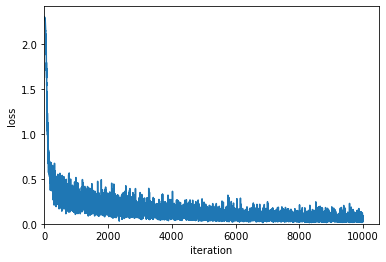

ValueError: x and y must have same first dimension, but have shapes (10000,) and (17,)

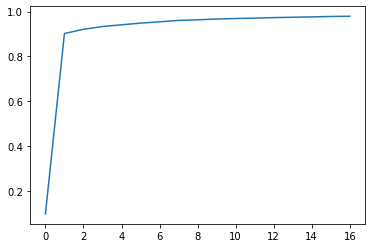

In [31]:
# 誤差逆伝播法での学習コード
# データの読み込み
# 訓練・教師画像、訓練・教師ラベル取得
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# ２層ニューラルネットの構成(入力28*28、隠れ層適当、出力0～9)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
optomizer = SGD()

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)
        
        
        
# 経過表示
print(f"[更新数]{i: >4} [損失関数の値]{loss:.4f} "f"[訓練データの認識精度]{train_acc:.4f} [テストデータの認識精度]{test_acc:.4f}")

# 損失関数の値の推移を描画
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='loss')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

# 訓練データとテストデータの認識精度の推移を描画
x2 = np.arange(len(train_acc_list))
plt.plot(x2, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(left=0)
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [32]:
class SCD:
    def __init__(self,lr=0.01):
        self.lr = lr
    
    def update(self,params,grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]